# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [3]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.65, 0.25], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.65, 0.25], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.55, 0.45], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process


# choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                  "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}
# preprocess_text = TextAugment([0.05, 0.2, 0.2, 0.3, 0.25], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

# choice_probas_test = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.0, "char_delete": 0.2,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                       "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}

# preprocess_text_test = TextAugment([0.1, 0.9], choice_probas_test, fasttext_file="wiki-news-300d-1M-subword.bin")

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


In [4]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

In [5]:


scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# Params

In [ ]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




# BERT Models

## Non Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.851	0.666


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs




## Head Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.05,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval Head Ensemble


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 20
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs

# 0.799	0.657 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.1,
# 0.780	0.634 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.15, 
# 0.806	0.648 gaussian_noise=0.0, dropout=0.02, word_masking_proba=0.1
# 0.803	0.655 gaussian_noise=0.0, dropout=0.1, word_masking_proba=0.1, (0.807	0.657) 0.803	0.653


## Decoder Ensemble

### Train All Params

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.718772 LR = 0.00000348



Epoch =  2 Loss = 0.550060 LR = 0.00000697



Epoch =  3 Loss = 0.498758 LR = 0.00001045



Epoch =  4 Loss = 0.483025 LR = 0.00001393



Epoch =  5 Loss = 0.474293 LR = 0.00001742



Epoch =  6 Loss = 0.468750 LR = 0.00002090



Epoch =  7 Loss = 0.464112 LR = 0.00002439



Epoch =  8 Loss = 0.445096 LR = 0.00002787



Epoch =  9 Loss = 0.433669 LR = 0.00003135



Epoch =  10 Loss = 0.427765 LR = 0.00003484



Epoch =  11 Loss = 0.410222 LR = 0.00003832



Epoch =  12 Loss = 0.407620 LR = 0.00004180



Epoch =  13 Loss = 0.395988 LR = 0.00004529



Epoch =  14 Loss = 0.392119 LR = 0.00004877



Epoch =  15 Loss = 0.388016 LR = 0.00004995



Epoch =  16 Loss = 0.378539 LR = 0.00004970



Epoch =  17 Loss = 0.380119 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.257 0.767     0   1
1      0.350 0.791     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.461,"[0.5391131639480591, 0.46088677644729614]",0,0,0.362,"[0.6375855803489685, 0.3624144196510315]",0,0,0.485,"[0.5150215029716492, 0.48497849702835083]",0,0
1,0.502,"[0.49781566858291626, 0.5021843314170837]",1,1,0.473,"[0.5270142555236816, 0.47298574447631836]",0,1,0.731,"[0.26916807889938354, 0.7308319211006165]",1,0
2,0.667,"[0.33346617221832275, 0.6665338277816772]",1,0,0.685,"[0.3153882324695587, 0.6846117377281189]",1,1,0.484,"[0.5161066055297852, 0.48389342427253723]",0,1
3,0.606,"[0.3939986824989319, 0.6060013175010681]",1,0,0.565,"[0.43538790941238403, 0.5646121501922607]",1,1,0.491,"[0.5088193416595459, 0.4911806881427765]",0,1
4,0.690,"[0.3097067177295685, 0.6902932524681091]",1,1,0.411,"[0.5887421369552612, 0.41125786304473877]",0,0,0.530,"[0.47012901306152344, 0.5298709869384766]",1,1


scores =  {'map': '0.6070', 'acc': '0.5820', 'auc': '0.6408'}
Epoch =  17 Train = 0.793770 Val = 0.640816



Epoch =  18 Loss = 0.363576 LR = 0.00004856



Epoch =  19 Loss = 0.350770 LR = 0.00004768



Epoch =  20 Loss = 0.351472 LR = 0.00004660



Epoch =  21 Loss = 0.350841 LR = 0.00004534



Epoch =  22 Loss = 0.362643 LR = 0.00004389



Epoch =  23 Loss = 0.353840 LR = 0.00004229



Epoch =  24 Loss = 0.353242 LR = 0.00004053



Epoch =  25 Loss = 0.346662 LR = 0.00003863



Epoch =  26 Loss = 0.337099 LR = 0.00003662


Exception for:  keyboard | ' ' ' ' | ['char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  27 Loss = 0.338021 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.116 0.820     0   1
1      0.218 0.804     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.536,"[0.4635389447212219, 0.5364610552787781]",1,0,0.500,"[0.500245213508606, 0.49975472688674927]",0,0,0.638,"[0.3620915412902832, 0.6379084587097168]",1,1
1,0.401,"[0.5989819765090942, 0.40101802349090576]",0,1,0.444,"[0.5563808083534241, 0.4436192214488983]",0,1,0.318,"[0.682303249835968, 0.317696750164032]",0,0
2,0.598,"[0.40168994665145874, 0.5983099937438965]",1,0,0.414,"[0.5861711502075195, 0.4138287901878357]",0,0,0.383,"[0.6168411374092102, 0.383158802986145]",0,0
3,0.426,"[0.5743964910507202, 0.425603449344635]",0,0,0.526,"[0.47432202100753784, 0.5256779789924622]",1,1,0.302,"[0.6977944374084473, 0.30220553278923035]",0,1
4,0.297,"[0.7027177810668945, 0.2972821593284607]",0,0,0.586,"[0.4137776494026184, 0.5862222909927368]",1,1,0.307,"[0.69254469871521, 0.30745524168014526]",0,0


scores =  {'map': '0.6090', 'acc': '0.5840', 'auc': '0.6449'}
Epoch =  27 Train = 0.826394 Val = 0.644920



Epoch =  28 Loss = 0.334243 LR = 0.00003231



Epoch =  29 Loss = 0.337152 LR = 0.00003005



Epoch =  30 Loss = 0.338960 LR = 0.00002774



Epoch =  31 Loss = 0.345512 LR = 0.00002541



Epoch =  32 Loss = 0.327440 LR = 0.00002308



Epoch =  33 Loss = 0.332765 LR = 0.00002076



Epoch =  34 Loss = 0.335312 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.062 0.790     0   1
1      0.118 0.785     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.375,"[0.6246748566627502, 0.37532514333724976]",0,1,0.474,"[0.5260006785392761, 0.4739993214607239]",0,0,0.199,"[0.8013868927955627, 0.19861312210559845]",0,0
1,0.626,"[0.37433922290802, 0.6256607174873352]",1,0,0.252,"[0.7484865188598633, 0.2515134811401367]",0,0,0.613,"[0.38710659742355347, 0.6128933429718018]",1,1
2,0.347,"[0.6533840298652649, 0.34661591053009033]",0,1,0.414,"[0.5856658816337585, 0.41433411836624146]",0,0,0.526,"[0.47387635707855225, 0.526123583316803]",1,1
3,0.405,"[0.5947701930999756, 0.40522974729537964]",0,1,0.372,"[0.6279582381248474, 0.3720417022705078]",0,0,0.180,"[0.8197525143623352, 0.18024751543998718]",0,0
4,0.502,"[0.4975951015949249, 0.5024048089981079]",1,1,0.159,"[0.8406492471694946, 0.1593507081270218]",0,1,0.369,"[0.6312727928161621, 0.3687271773815155]",0,1


scores =  {'map': '0.6057', 'acc': '0.5620', 'auc': '0.6462'}
Epoch =  34 Train = 0.841295 Val = 0.646192



Epoch =  35 Loss = 0.330259 LR = 0.00001626



Epoch =  36 Loss = 0.333742 LR = 0.00001412



Epoch =  37 Loss = 0.334051 LR = 0.00001207



Epoch =  38 Loss = 0.331695 LR = 0.00001013


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  39 Loss = 0.327759 LR = 0.00000832



Epoch =  40 Loss = 0.328073 LR = 0.00000666



Epoch =  41 Loss = 0.324816 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.047 0.775     0   1
1      0.107 0.816     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.418,"[0.5821535587310791, 0.41784635186195374]",0,0,0.316,"[0.6843077540397644, 0.3156922459602356]",0,0,0.355,"[0.6450698375701904, 0.3549301028251648]",0,1
1,0.491,"[0.5089985132217407, 0.4910014569759369]",0,1,0.275,"[0.7253762483596802, 0.2746237814426422]",0,0,0.641,"[0.35865893959999084, 0.6413410305976868]",1,0
2,0.534,"[0.4661112129688263, 0.5338887572288513]",1,0,0.343,"[0.6566886901855469, 0.3433113098144531]",0,0,0.527,"[0.47314882278442383, 0.5268511772155762]",1,1
3,0.407,"[0.592505693435669, 0.40749430656433105]",0,1,0.406,"[0.5940530896186829, 0.40594685077667236]",0,0,0.454,"[0.546270489692688, 0.45372945070266724]",0,0
4,0.444,"[0.5562214255332947, 0.44377854466438293]",0,0,0.351,"[0.6485176086425781, 0.35148242115974426]",0,0,0.200,"[0.8003178238868713, 0.1996820867061615]",0,0


scores =  {'map': '0.6082', 'acc': '0.5580', 'auc': '0.6465'}
Epoch =  41 Train = 0.848161 Val = 0.646512



Epoch =  42 Loss = 0.323047 LR = 0.00000382



Epoch =  43 Loss = 0.329718 LR = 0.00000268



Epoch =  44 Loss = 0.331861 LR = 0.00000172



Epoch =  45 Loss = 0.328100 LR = 0.00000097



Epoch =  46 Loss = 0.329676 LR = 0.00000043



Epoch =  47 Loss = 0.323695 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.791     0   1
1      0.119 0.817     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.330,"[0.6696552634239197, 0.3303447365760803]",0,1,0.314,"[0.686339259147644, 0.31366071105003357]",0,1,0.629,"[0.37136155366897583, 0.6286383867263794]",1,0
1,0.755,"[0.2447725087404251, 0.7552274465560913]",1,1,0.464,"[0.5361583232879639, 0.46384161710739136]",0,0,0.694,"[0.30621734261512756, 0.69378262758255]",1,1
2,0.326,"[0.6737571358680725, 0.3262428343296051]",0,0,0.671,"[0.329273521900177, 0.6707264184951782]",1,1,0.556,"[0.44425448775291443, 0.5557454824447632]",1,1
3,0.382,"[0.6184097528457642, 0.38159021735191345]",0,0,0.534,"[0.46580037474632263, 0.534199595451355]",1,1,0.648,"[0.3519119620323181, 0.6480880379676819]",1,1
4,0.677,"[0.32348841428756714, 0.6765115261077881]",1,0,0.498,"[0.5016240477561951, 0.49837589263916016]",0,1,0.571,"[0.42937171459198, 0.57062828540802]",1,0


scores =  {'map': '0.6114', 'acc': '0.5640', 'auc': '0.6508'}
Epoch =  47 Train = 0.849509 Val = 0.650800



Epoch =  48 Loss = 0.322944 LR = 0.00000000



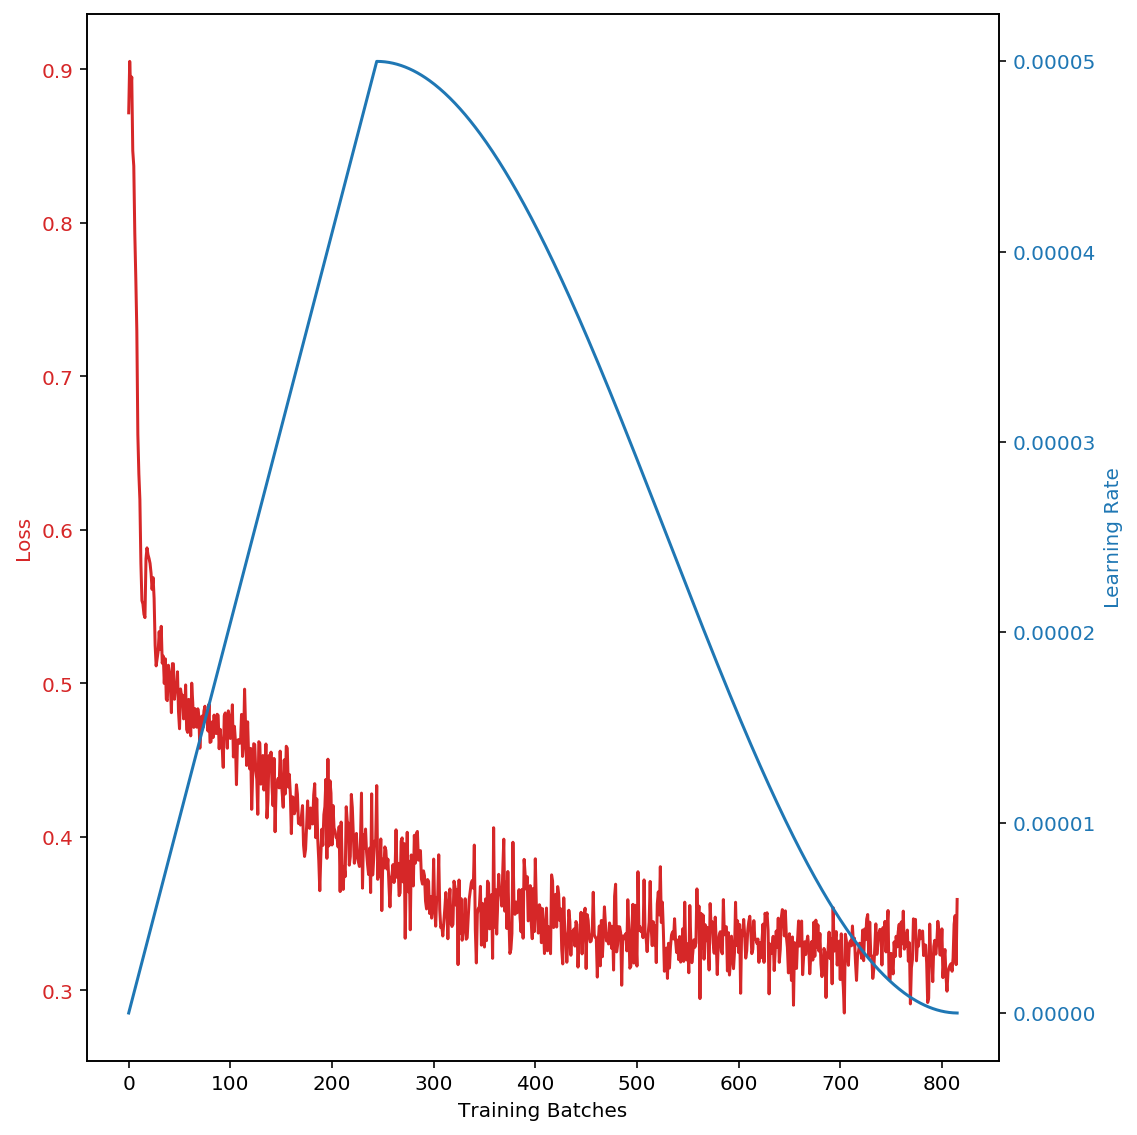

Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.792     0   1
1      0.119 0.818     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.506,"[0.4943177103996277, 0.5056822896003723]",1,0,0.458,"[0.5419405102729797, 0.45805948972702026]",0,1,0.417,"[0.5834930539131165, 0.41650694608688354]",0,0
1,0.480,"[0.519960343837738, 0.48003965616226196]",0,1,0.370,"[0.6301073431968689, 0.36989259719848633]",0,0,0.439,"[0.5610328912734985, 0.4389670789241791]",0,1
2,0.385,"[0.6153403520584106, 0.38465964794158936]",0,0,0.416,"[0.5844233632087708, 0.41557660698890686]",0,0,0.707,"[0.29274964332580566, 0.7072503566741943]",1,0
3,0.326,"[0.6741451621055603, 0.3258548676967621]",0,0,0.499,"[0.5005703568458557, 0.4994296133518219]",0,1,0.682,"[0.3184809982776642, 0.6815189719200134]",1,1
4,0.291,"[0.7093660831451416, 0.2906338572502136]",0,1,0.369,"[0.6306499242782593, 0.3693500757217407]",0,1,0.414,"[0.5855351686477661, 0.4144647717475891]",0,0


scores =  {'map': '0.6114', 'acc': '0.5680', 'auc': '0.6508'}


train   val
mean_or_std metric               
mean        map       0.780 0.611
            accuracy  0.771 0.568
            auc       0.850 0.651
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.835  0.801 0.817 5450.000     0.552  0.728 0.628 250.000
pos     0.668  0.717 0.692 3050.000     0.600  0.408 0.486 250.000

In [31]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.025,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

# 0.854	0.654 0.651 0.646 x2
# MLM = 0.854	0.646
# No focal 0.851	0.647 (0.766	0.556)


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  56 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.693817 LR = 0.00000149



Epoch =  2 Loss = 0.592762 LR = 0.00000298



Epoch =  3 Loss = 0.566228 LR = 0.00000447



Epoch =  4 Loss = 0.555877 LR = 0.00000596



Epoch =  5 Loss = 0.548087 LR = 0.00000746



Epoch =  6 Loss = 0.530008 LR = 0.00000895



Epoch =  7 Loss = 0.513579 LR = 0.00001044



Epoch =  8 Loss = 0.499346 LR = 0.00001193



Epoch =  9 Loss = 0.497599 LR = 0.00001342



Epoch =  10 Loss = 0.505649 LR = 0.00001491



Epoch =  11 Loss = 0.470327 LR = 0.00001640



Epoch =  12 Loss = 0.465575 LR = 0.00001789



Epoch =  13 Loss = 0.456832 LR = 0.00001939



Epoch =  14 Loss = 0.441019 LR = 0.00002088



Epoch =  15 Loss = 0.443088 LR = 0.00002237



Epoch =  16 Loss = 0.447570 LR = 0.00002386



Epoch =  17 Loss = 0.438798 LR = 0.00002500


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.678     0   1
1      0.140 0.718     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.326,"[0.6735860109329224, 0.32641392946243286]",0,1,0.321,"[0.6792784929275513, 0.32072144746780396]",0,0,0.407,"[0.5925323963165283, 0.4074675440788269]",0,1
1,0.552,"[0.4476003646850586, 0.5523996353149414]",1,1,0.395,"[0.6047577261924744, 0.39524227380752563]",0,0,0.111,"[0.888601541519165, 0.11139844357967377]",0,0
2,0.331,"[0.6685856580734253, 0.3314144015312195]",0,1,0.212,"[0.7884982824325562, 0.21150171756744385]",0,1,0.237,"[0.762617826461792, 0.23738214373588562]",0,1
3,0.289,"[0.7113529443740845, 0.28864702582359314]",0,0,0.136,"[0.8640451431274414, 0.13595479726791382]",0,0,0.417,"[0.5832287073135376, 0.4167712926864624]",0,0
4,0.305,"[0.6950263977050781, 0.3049735426902771]",0,1,0.612,"[0.38764163851737976, 0.6123583316802979]",1,1,0.143,"[0.8569101691246033, 0.14308983087539673]",0,0


scores =  {'map': '0.5963', 'acc': '0.5240', 'auc': '0.6231'}
Epoch =  17 Train = 0.784517 Val = 0.623120


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  18 Loss = 0.436490 LR = 0.00002494



Epoch =  19 Loss = 0.414530 LR = 0.00002480



Epoch =  20 Loss = 0.408522 LR = 0.00002458



Epoch =  21 Loss = 0.410029 LR = 0.00002429


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  22 Loss = 0.415834 LR = 0.00002392



Epoch =  23 Loss = 0.433877 LR = 0.00002347



Epoch =  24 Loss = 0.397888 LR = 0.00002296



Epoch =  25 Loss = 0.389034 LR = 0.00002238



Epoch =  26 Loss = 0.400461 LR = 0.00002174



Epoch =  27 Loss = 0.390971 LR = 0.00002103


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.697     0   1
1      0.144 0.758     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.332,"[0.6675203442573547, 0.3324796259403229]",0,0,0.255,"[0.7454895377159119, 0.25451040267944336]",0,0,0.672,"[0.328235387802124, 0.6717645525932312]",1,0
1,0.220,"[0.7803990244865417, 0.21960094571113586]",0,0,0.341,"[0.6588400602340698, 0.3411599397659302]",0,1,0.504,"[0.496135950088501, 0.503864049911499]",1,1
2,0.373,"[0.6265850067138672, 0.37341493368148804]",0,1,0.515,"[0.48470839858055115, 0.5152915716171265]",1,1,0.392,"[0.608165979385376, 0.391834020614624]",0,1
3,0.384,"[0.616107165813446, 0.38389286398887634]",0,0,0.173,"[0.8266434669494629, 0.17335650324821472]",0,0,0.384,"[0.616107165813446, 0.38389286398887634]",0,1
4,0.268,"[0.7320501804351807, 0.2679498493671417]",0,0,0.251,"[0.7491154670715332, 0.2508845031261444]",0,1,0.220,"[0.7799413800239563, 0.22005857527256012]",0,1


scores =  {'map': '0.6022', 'acc': '0.5420', 'auc': '0.6313'}
Epoch =  27 Train = 0.816965 Val = 0.631280



Epoch =  28 Loss = 0.384910 LR = 0.00002027



Epoch =  29 Loss = 0.378276 LR = 0.00001947



Epoch =  30 Loss = 0.372948 LR = 0.00001861



Epoch =  31 Loss = 0.365685 LR = 0.00001772



Epoch =  32 Loss = 0.373271 LR = 0.00001680


Exception for:  keyboard | ' ' ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  33 Loss = 0.368499 LR = 0.00001584



Epoch =  34 Loss = 0.366455 LR = 0.00001487


Proba       Preds    
         min   max   min max
Labels                      
0      0.096 0.747     0   1
1      0.187 0.811     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.291,"[0.7089537382125854, 0.29104623198509216]",0,1,0.512,"[0.4882551431655884, 0.5117448568344116]",1,0,0.241,"[0.7586216926574707, 0.2413783073425293]",0,0
1,0.293,"[0.7069728374481201, 0.2930271625518799]",0,0,0.528,"[0.47187644243240356, 0.5281236171722412]",1,1,0.228,"[0.7722924947738647, 0.22770747542381287]",0,0
2,0.453,"[0.5474585294723511, 0.4525415003299713]",0,1,0.218,"[0.7819173336029053, 0.21808265149593353]",0,0,0.656,"[0.3436698615550995, 0.6563301086425781]",1,1
3,0.144,"[0.8560547828674316, 0.14394524693489075]",0,0,0.453,"[0.5474836826324463, 0.45251625776290894]",0,1,0.457,"[0.5432570576667786, 0.45674291253089905]",0,1
4,0.532,"[0.4680182933807373, 0.5319817066192627]",1,1,0.583,"[0.41734200716018677, 0.5826579332351685]",1,0,0.527,"[0.47262343764305115, 0.5273765325546265]",1,1


scores =  {'map': '0.6094', 'acc': '0.5500', 'auc': '0.6398'}
Epoch =  34 Train = 0.833769 Val = 0.639760



Epoch =  35 Loss = 0.363882 LR = 0.00001388



Epoch =  36 Loss = 0.359039 LR = 0.00001288



Epoch =  37 Loss = 0.369695 LR = 0.00001188



Epoch =  38 Loss = 0.355604 LR = 0.00001089



Epoch =  39 Loss = 0.354957 LR = 0.00000990



Epoch =  40 Loss = 0.353988 LR = 0.00000893



Epoch =  41 Loss = 0.353639 LR = 0.00000798


Proba       Preds    
         min   max   min max
Labels                      
0      0.069 0.801     0   1
1      0.184 0.779     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.388,"[0.6123794317245483, 0.38762056827545166]",0,0,0.603,"[0.3973381519317627, 0.6026618480682373]",1,1,0.657,"[0.3427031636238098, 0.6572967767715454]",1,0
1,0.518,"[0.4818495810031891, 0.5181503295898438]",1,1,0.604,"[0.3959037661552429, 0.6040961742401123]",1,0,0.425,"[0.5750235915184021, 0.42497631907463074]",0,0
2,0.516,"[0.48368215560913086, 0.5163177847862244]",1,1,0.590,"[0.4097056984901428, 0.5902942419052124]",1,1,0.289,"[0.7113732099533081, 0.2886267900466919]",0,0
3,0.434,"[0.5660718083381653, 0.43392816185951233]",0,1,0.624,"[0.37649106979370117, 0.6235089302062988]",1,1,0.353,"[0.6472706198692322, 0.35272935032844543]",0,0
4,0.340,"[0.6600748896598816, 0.339925080537796]",0,1,0.357,"[0.6432638764381409, 0.35673612356185913]",0,0,0.611,"[0.3893555700778961, 0.6106444001197815]",1,1


scores =  {'map': '0.6067', 'acc': '0.5680', 'auc': '0.6445'}
Epoch =  41 Train = 0.844079 Val = 0.644544



Epoch =  42 Loss = 0.347794 LR = 0.00000707



Epoch =  43 Loss = 0.355471 LR = 0.00000618



Epoch =  44 Loss = 0.349166 LR = 0.00000534



Epoch =  45 Loss = 0.353196 LR = 0.00000454



Epoch =  46 Loss = 0.342063 LR = 0.00000380



Epoch =  47 Loss = 0.348893 LR = 0.00000311


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.800     0   1
1      0.150 0.787     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.509,"[0.4913639426231384, 0.5086359977722168]",1,1,0.226,"[0.773829460144043, 0.22617049515247345]",0,0,0.666,"[0.3336986005306244, 0.6663013696670532]",1,1
1,0.571,"[0.4292832314968109, 0.5707167387008667]",1,0,0.489,"[0.510711133480072, 0.489288866519928]",0,1,0.219,"[0.781286358833313, 0.21871358156204224]",0,1
2,0.242,"[0.7576575875282288, 0.24234238266944885]",0,0,0.502,"[0.49778491258621216, 0.5022151470184326]",1,0,0.443,"[0.5574558973312378, 0.4425440728664398]",0,1
3,0.384,"[0.6156567335128784, 0.3843432366847992]",0,0,0.440,"[0.5604334473609924, 0.43956655263900757]",0,1,0.321,"[0.6786003112792969, 0.3213997185230255]",0,1
4,0.190,"[0.809994101524353, 0.19000588357448578]",0,0,0.381,"[0.6188890933990479, 0.38111090660095215]",0,0,0.416,"[0.5836459398269653, 0.41635406017303467]",0,1


scores =  {'map': '0.6059', 'acc': '0.5560', 'auc': '0.6406'}
Epoch =  47 Train = 0.849852 Val = 0.640608



Epoch =  48 Loss = 0.345936 LR = 0.00000248



Epoch =  49 Loss = 0.349147 LR = 0.00000191



Epoch =  50 Loss = 0.343726 LR = 0.00000142



Epoch =  51 Loss = 0.344227 LR = 0.00000099


Proba       Preds    
         min   max   min max
Labels                      
0      0.057 0.801     0   1
1      0.141 0.790     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.306,"[0.6935570240020752, 0.30644291639328003]",0,0,0.320,"[0.6800438165664673, 0.3199561536312103]",0,1,0.402,"[0.5978609323501587, 0.4021390676498413]",0,1
1,0.361,"[0.6394314169883728, 0.3605685234069824]",0,0,0.543,"[0.45663270354270935, 0.5433672666549683]",1,0,0.535,"[0.4645266830921173, 0.5354733467102051]",1,1
2,0.346,"[0.6539775729179382, 0.346022367477417]",0,1,0.434,"[0.5659788846969604, 0.43402108550071716]",0,1,0.205,"[0.794876754283905, 0.2051231861114502]",0,0
3,0.181,"[0.8190778493881226, 0.18092209100723267]",0,0,0.284,"[0.7164740562438965, 0.28352588415145874]",0,1,0.286,"[0.7143470048904419, 0.28565293550491333]",0,0
4,0.513,"[0.4872809648513794, 0.5127189755439758]",1,0,0.352,"[0.6481639742851257, 0.35183602571487427]",0,0,0.366,"[0.634092390537262, 0.36590757966041565]",0,0


scores =  {'map': '0.6103', 'acc': '0.5660', 'auc': '0.6446'}
Epoch =  51 Train = 0.850294 Val = 0.644576



Epoch =  52 Loss = 0.341734 LR = 0.00000064



Epoch =  53 Loss = 0.340628 LR = 0.00000036



Epoch =  54 Loss = 0.344826 LR = 0.00000016


Proba       Preds    
         min   max   min max
Labels                      
0      0.065 0.827     0   1
1      0.159 0.819     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.283,"[0.7166962623596191, 0.28330370783805847]",0,0,0.578,"[0.42221367359161377, 0.5777862071990967]",1,1,0.501,"[0.4988391101360321, 0.5011608600616455]",1,0
1,0.404,"[0.5958144068717957, 0.40418556332588196]",0,1,0.424,"[0.5762948989868164, 0.4237050712108612]",0,1,0.792,"[0.20836807787418365, 0.7916319370269775]",1,0
2,0.111,"[0.8886725902557373, 0.11132741719484329]",0,0,0.320,"[0.6800625324249268, 0.319937527179718]",0,0,0.521,"[0.47883036732673645, 0.5211695432662964]",1,0
3,0.580,"[0.4199727177619934, 0.5800272822380066]",1,1,0.153,"[0.8470019102096558, 0.15299810469150543]",0,0,0.258,"[0.7415542006492615, 0.25844573974609375]",0,1
4,0.402,"[0.5984390377998352, 0.4015609323978424]",0,1,0.426,"[0.5743200778961182, 0.42567992210388184]",0,1,0.628,"[0.37178856134414673, 0.6282113790512085]",1,0


scores =  {'map': '0.6105', 'acc': '0.5680', 'auc': '0.6446'}
Epoch =  54 Train = 0.850712 Val = 0.644576



Epoch =  55 Loss = 0.340601 LR = 0.00000004



Epoch =  56 Loss = 0.342802 LR = 0.00000000



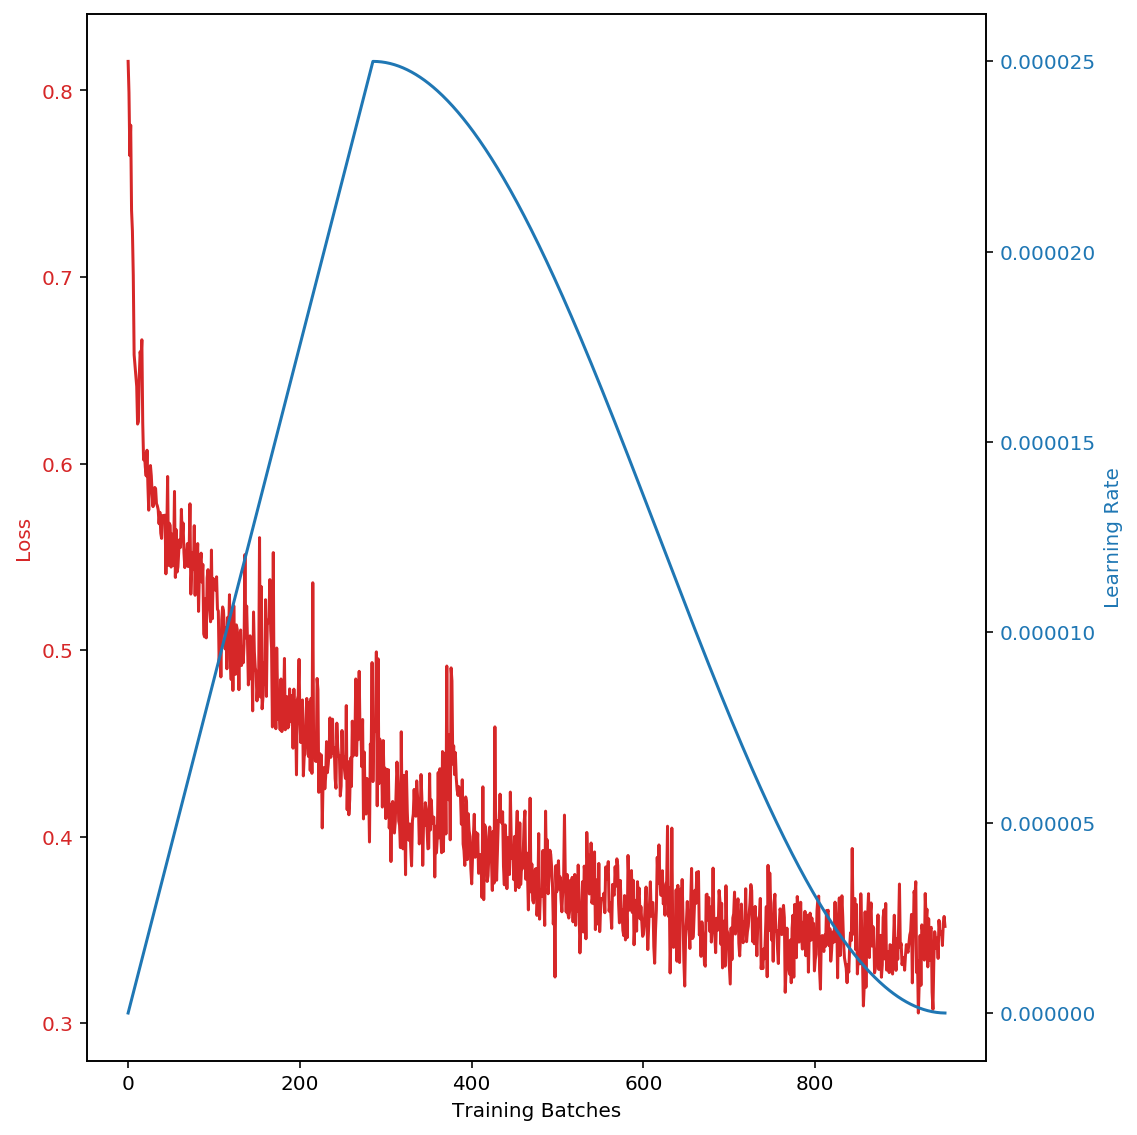

Proba       Preds    
         min   max   min max
Labels                      
0      0.064 0.824     0   1
1      0.157 0.815     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.226,"[0.7740835547447205, 0.22591647505760193]",0,0,0.264,"[0.7355028986930847, 0.2644970715045929]",0,0,0.619,"[0.38055098056793213, 0.6194489598274231]",1,1
1,0.467,"[0.5330854058265686, 0.4669145345687866]",0,1,0.228,"[0.7720579504966736, 0.22794204950332642]",0,0,0.586,"[0.41422411799430847, 0.5857758522033691]",1,1
2,0.425,"[0.5747837424278259, 0.4252162277698517]",0,1,0.459,"[0.5409589409828186, 0.4590410590171814]",0,0,0.399,"[0.600562572479248, 0.3994373679161072]",0,1
3,0.522,"[0.47813206911087036, 0.5218679308891296]",1,0,0.266,"[0.7335094213485718, 0.26649054884910583]",0,1,0.434,"[0.5657378435134888, 0.43426206707954407]",0,0
4,0.375,"[0.6249487400054932, 0.37505120038986206]",0,0,0.594,"[0.4062751531600952, 0.5937248468399048]",1,1,0.428,"[0.571652889251709, 0.428347110748291]",0,1


scores =  {'map': '0.6101', 'acc': '0.5620', 'auc': '0.6444'}


train   val
mean_or_std metric               
mean        map       0.777 0.610
            accuracy  0.761 0.562
            auc       0.851 0.644
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.846  0.767 0.804 5450.000     0.550  0.684 0.610 250.000
pos     0.643  0.750 0.692 3050.000     0.582  0.440 0.501 250.000

In [32]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/4,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 28
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r3, p3 = results, prfs
results
prfs

# 0.853	0.655 (0.765	0.570)
# 0.863	0.651 (0.778	0.570)


### Train Head First

In [6]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.8, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)




Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  12 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.608698 LR = 0.00002787



Epoch =  2 Loss = 0.544649 LR = 0.00005574



Epoch =  3 Loss = 0.504770 LR = 0.00008361



Epoch =  4 Loss = 0.487307 LR = 0.00009941



Epoch =  5 Loss = 0.443573 LR = 0.00009321



Epoch =  6 Loss = 0.450222 LR = 0.00008105



Epoch =  7 Loss = 0.436291 LR = 0.00006461



Epoch =  8 Loss = 0.411722 LR = 0.00004616



Epoch =  9 Loss = 0.403362 LR = 0.00002824



Epoch =  10 Loss = 0.393931 LR = 0.00001331



Epoch =  11 Loss = 0.393932 LR = 0.00000345



Epoch =  12 Loss = 0.392635 LR = 0.00000000



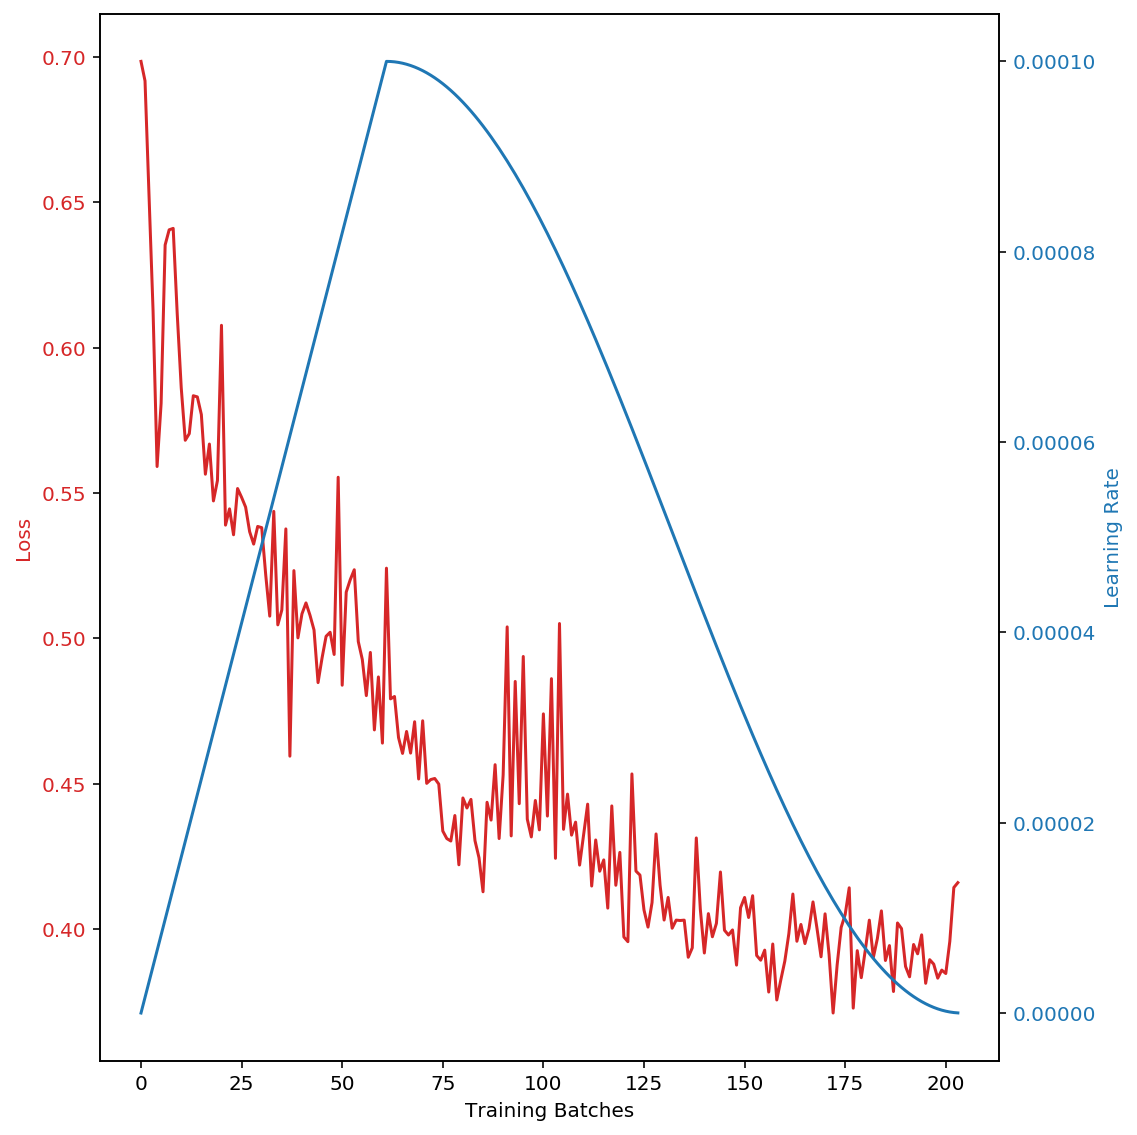

Proba       Preds    
         min   max   min max
Labels                      
0      0.266 0.670     0   1
1      0.304 0.653     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.420,"[0.5798009634017944, 0.42019903659820557]",0,1,0.428,"[0.572174072265625, 0.427825927734375]",0,0,0.511,"[0.4893229603767395, 0.5106770396232605]",1,1
1,0.524,"[0.47643840312957764, 0.5235615968704224]",1,1,0.443,"[0.5565060377120972, 0.4434940218925476]",0,1,0.336,"[0.6639789342880249, 0.3360210359096527]",0,1
2,0.507,"[0.49314504861831665, 0.5068549513816833]",1,1,0.440,"[0.5603290796279907, 0.4396708905696869]",0,1,0.563,"[0.43714818358421326, 0.5628517866134644]",1,1
3,0.507,"[0.4934847950935364, 0.5065151453018188]",1,1,0.440,"[0.5602853298187256, 0.4397146701812744]",0,0,0.479,"[0.5212990641593933, 0.4787009358406067]",0,1
4,0.397,"[0.6031924486160278, 0.39680755138397217]",0,0,0.464,"[0.5355226993560791, 0.4644772708415985]",0,0,0.631,"[0.36934971809387207, 0.6306502223014832]",1,0


scores =  {'map': '0.5813', 'acc': '0.5540', 'auc': '0.5979'}


train   val
mean_or_std metric               
mean        map       0.579 0.581
            accuracy  0.673 0.554
            auc       0.703 0.598
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.751  0.732 0.741 5450.000     0.542  0.692 0.608 250.000
pos     0.542  0.566 0.554 3050.000     0.575  0.416 0.483 250.000

Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.389656 LR = 0.00000209



Epoch =  2 Loss = 0.386973 LR = 0.00000418



Epoch =  3 Loss = 0.389702 LR = 0.00000627



Epoch =  4 Loss = 0.385222 LR = 0.00000836



Epoch =  5 Loss = 0.386269 LR = 0.00001045



Epoch =  6 Loss = 0.394739 LR = 0.00001254



Epoch =  7 Loss = 0.391760 LR = 0.00001463



Epoch =  8 Loss = 0.385344 LR = 0.00001672



Epoch =  9 Loss = 0.389068 LR = 0.00001881



Epoch =  10 Loss = 0.379399 LR = 0.00002090



Epoch =  11 Loss = 0.381089 LR = 0.00002299



Epoch =  12 Loss = 0.379113 LR = 0.00002508



Epoch =  13 Loss = 0.374628 LR = 0.00002717



Epoch =  14 Loss = 0.386693 LR = 0.00002926



Epoch =  15 Loss = 0.375751 LR = 0.00002997


Proba       Preds    
         min   max   min max
Labels                      
0      0.121 0.817     0   1
1      0.193 0.833     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.322,"[0.6778502464294434, 0.3221496641635895]",0,1,0.268,"[0.7319133281707764, 0.26808661222457886]",0,0,0.352,"[0.6483962535858154, 0.35160374641418457]",0,0
1,0.430,"[0.5702992677688599, 0.42970073223114014]",0,0,0.487,"[0.5132973790168762, 0.4867026209831238]",0,0,0.508,"[0.4915691614151001, 0.5084308385848999]",1,1
2,0.390,"[0.6103485822677612, 0.38965141773223877]",0,0,0.384,"[0.6164299249649048, 0.3835701048374176]",0,1,0.396,"[0.6043717861175537, 0.3956282138824463]",0,0
3,0.509,"[0.49095019698143005, 0.5090497732162476]",1,1,0.413,"[0.5866870880126953, 0.4133129119873047]",0,0,0.250,"[0.7495254278182983, 0.2504745423793793]",0,0
4,0.383,"[0.617050051689148, 0.3829498887062073]",0,1,0.350,"[0.6501064300537109, 0.3498935401439667]",0,0,0.487,"[0.5129984617233276, 0.48700156807899475]",0,1


scores =  {'map': '0.6073', 'acc': '0.5640', 'auc': '0.6392'}
Epoch =  15 Train = 0.788904 Val = 0.639232



Epoch =  16 Loss = 0.372920 LR = 0.00002982



Epoch =  17 Loss = 0.371530 LR = 0.00002954



Epoch =  18 Loss = 0.364685 LR = 0.00002914



Epoch =  19 Loss = 0.366646 LR = 0.00002861



Epoch =  20 Loss = 0.365190 LR = 0.00002796



Epoch =  21 Loss = 0.363045 LR = 0.00002720


Proba       Preds    
         min   max   min max
Labels                      
0      0.107 0.721     0   1
1      0.159 0.741     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.431,"[0.5692043304443359, 0.43079566955566406]",0,1,0.581,"[0.41929885745048523, 0.5807011127471924]",1,1,0.509,"[0.49136877059936523, 0.50863116979599]",1,1
1,0.248,"[0.7519640922546387, 0.24803586304187775]",0,1,0.402,"[0.5977894067764282, 0.4022105634212494]",0,1,0.217,"[0.7826755046844482, 0.21732451021671295]",0,0
2,0.230,"[0.7698955535888672, 0.2301044464111328]",0,0,0.482,"[0.5181719064712524, 0.48182809352874756]",0,1,0.267,"[0.7325846552848816, 0.2674153745174408]",0,1
3,0.420,"[0.5798803567886353, 0.42011958360671997]",0,1,0.170,"[0.8296399116516113, 0.17036011815071106]",0,0,0.477,"[0.5228992700576782, 0.477100670337677]",0,1
4,0.351,"[0.6488162875175476, 0.3511837124824524]",0,0,0.332,"[0.6680010557174683, 0.33199894428253174]",0,0,0.550,"[0.45041710138320923, 0.5495828986167908]",1,1


scores =  {'map': '0.5989', 'acc': '0.5320', 'auc': '0.6384'}
Epoch =  21 Train = 0.812800 Val = 0.638400



Epoch =  22 Loss = 0.360198 LR = 0.00002634



Epoch =  23 Loss = 0.367795 LR = 0.00002537



Epoch =  24 Loss = 0.356624 LR = 0.00002432



Epoch =  25 Loss = 0.352687 LR = 0.00002318



Epoch =  26 Loss = 0.354029 LR = 0.00002197



Epoch =  27 Loss = 0.353902 LR = 0.00002070



Epoch =  28 Loss = 0.350767 LR = 0.00001938



Epoch =  29 Loss = 0.357551 LR = 0.00001803



Epoch =  30 Loss = 0.363996 LR = 0.00001664



Epoch =  31 Loss = 0.362182 LR = 0.00001525


Proba       Preds    
         min   max   min max
Labels                      
0      0.084 0.830     0   1
1      0.178 0.873     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.445,"[0.554530143737793, 0.44546985626220703]",0,1,0.621,"[0.37850016355514526, 0.6214998364448547]",1,0,0.519,"[0.4809286594390869, 0.5190713405609131]",1,1
1,0.412,"[0.5883753895759583, 0.411624550819397]",0,0,0.642,"[0.3575494885444641, 0.6424505114555359]",1,1,0.394,"[0.6061903238296509, 0.39380958676338196]",0,1
2,0.305,"[0.6952533721923828, 0.3047465682029724]",0,1,0.423,"[0.5772246718406677, 0.4227753281593323]",0,1,0.457,"[0.5425337553024292, 0.4574662148952484]",0,0
3,0.674,"[0.32647716999053955, 0.6735227704048157]",1,0,0.203,"[0.7974488735198975, 0.20255108177661896]",0,0,0.461,"[0.5389096736907959, 0.4610903561115265]",0,1
4,0.303,"[0.697386622428894, 0.30261343717575073]",0,0,0.406,"[0.5935331583023071, 0.40646684169769287]",0,1,0.650,"[0.34968507289886475, 0.6503149271011353]",1,1


scores =  {'map': '0.6183', 'acc': '0.5900', 'auc': '0.6542'}
Epoch =  31 Train = 0.836273 Val = 0.654168



Epoch =  32 Loss = 0.345296 LR = 0.00001385



Epoch =  33 Loss = 0.348631 LR = 0.00001246



Epoch =  34 Loss = 0.342174 LR = 0.00001109



Epoch =  35 Loss = 0.339632 LR = 0.00000976



Epoch =  36 Loss = 0.342261 LR = 0.00000847



Epoch =  37 Loss = 0.343020 LR = 0.00000724



Epoch =  38 Loss = 0.344712 LR = 0.00000608



Epoch =  39 Loss = 0.340756 LR = 0.00000499



Epoch =  40 Loss = 0.344682 LR = 0.00000399



Epoch =  41 Loss = 0.342595 LR = 0.00000309


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.782     0   1
1      0.129 0.833     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.613,"[0.38746917247772217, 0.6125308275222778]",1,0,0.200,"[0.7996536493301392, 0.20034633576869965]",0,1,0.515,"[0.48463451862335205, 0.5153654217720032]",1,1
1,0.477,"[0.5233443975448608, 0.4766555726528168]",0,1,0.550,"[0.44974443316459656, 0.550255537033081]",1,1,0.229,"[0.7706038951873779, 0.2293960303068161]",0,0
2,0.290,"[0.7099217176437378, 0.29007822275161743]",0,0,0.219,"[0.7805302143096924, 0.21946981549263]",0,0,0.478,"[0.5218510627746582, 0.4781489670276642]",0,1
3,0.193,"[0.8071762919425964, 0.19282370805740356]",0,0,0.557,"[0.4429055154323578, 0.557094395160675]",1,1,0.625,"[0.3754606246948242, 0.624539315700531]",1,0
4,0.218,"[0.7822815179824829, 0.21771842241287231]",0,0,0.204,"[0.7956947088241577, 0.2043052762746811]",0,0,0.455,"[0.5447008609771729, 0.45529913902282715]",0,0


scores =  {'map': '0.6192', 'acc': '0.5660', 'auc': '0.6578'}
Epoch =  41 Train = 0.846425 Val = 0.657792



Epoch =  42 Loss = 0.337499 LR = 0.00000229



Epoch =  43 Loss = 0.342909 LR = 0.00000161



Epoch =  44 Loss = 0.341766 LR = 0.00000103



Epoch =  45 Loss = 0.337016 LR = 0.00000058



Epoch =  46 Loss = 0.335568 LR = 0.00000026


Proba       Preds    
         min   max   min max
Labels                      
0      0.056 0.802     0   1
1      0.131 0.851     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.461,"[0.5387355089187622, 0.4612645208835602]",0,1,0.455,"[0.5454649329185486, 0.45453500747680664]",0,0,0.647,"[0.35347485542297363, 0.6465251445770264]",1,0
1,0.194,"[0.8062863349914551, 0.1937136948108673]",0,0,0.385,"[0.6145011186599731, 0.38549888134002686]",0,0,0.585,"[0.4145416021347046, 0.5854583978652954]",1,1
2,0.336,"[0.6643679738044739, 0.33563196659088135]",0,0,0.243,"[0.7565191984176636, 0.24348080158233643]",0,0,0.331,"[0.6686716079711914, 0.3313283920288086]",0,1
3,0.440,"[0.5597732067108154, 0.44022682309150696]",0,0,0.393,"[0.6065634489059448, 0.3934365510940552]",0,0,0.536,"[0.4644591808319092, 0.5355408191680908]",1,1
4,0.465,"[0.5347679257392883, 0.46523207426071167]",0,1,0.269,"[0.7308416962623596, 0.2691583037376404]",0,0,0.574,"[0.42589470744132996, 0.5741052627563477]",1,0


scores =  {'map': '0.6174', 'acc': '0.5780', 'auc': '0.6556'}
Epoch =  46 Train = 0.847288 Val = 0.655616



Epoch =  47 Loss = 0.342341 LR = 0.00000007



Epoch =  48 Loss = 0.340103 LR = 0.00000000



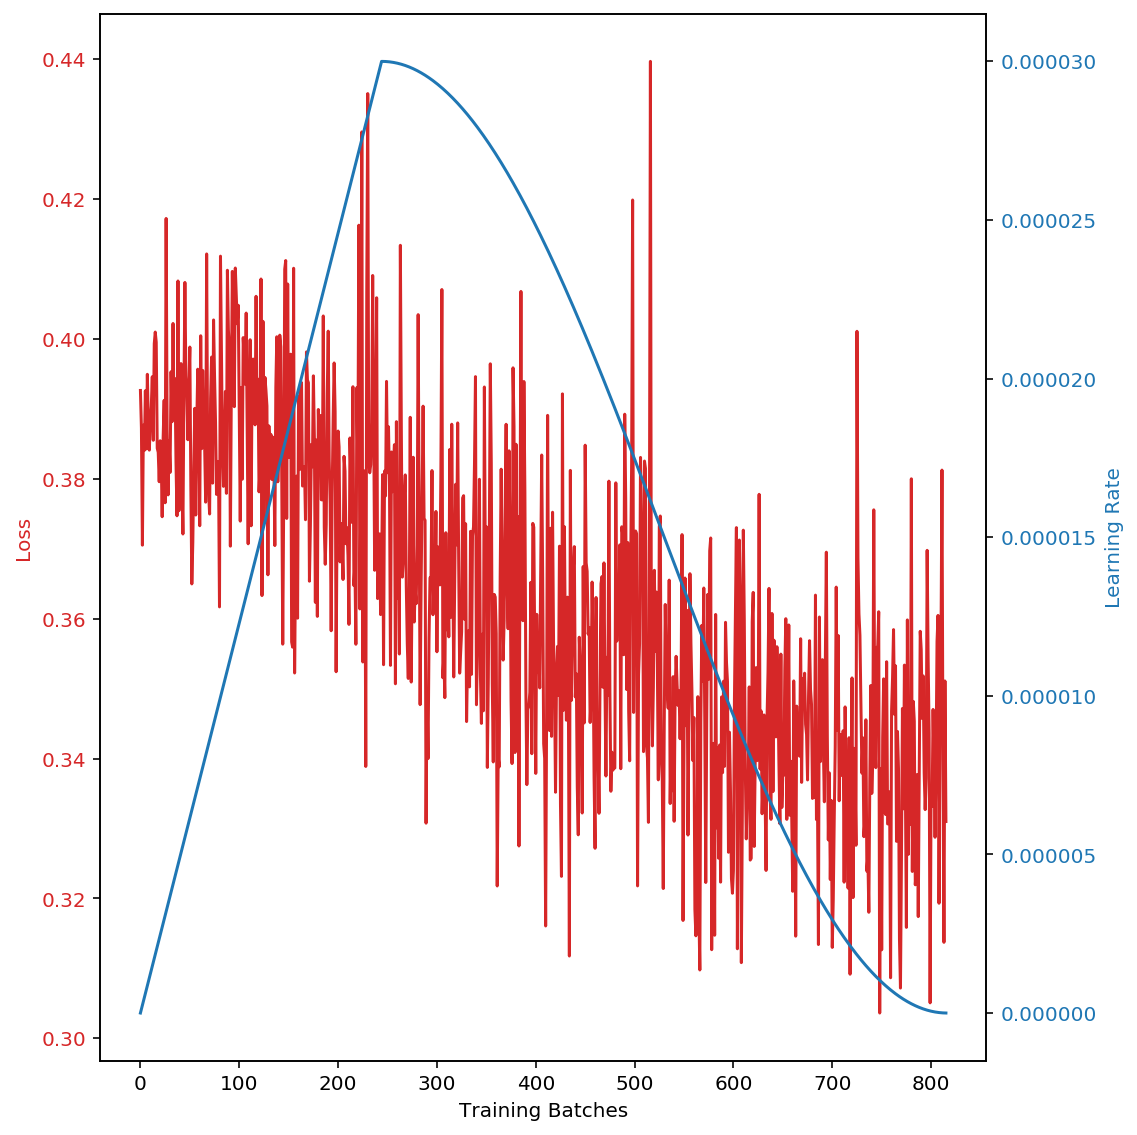

Proba       Preds    
         min   max   min max
Labels                      
0      0.056 0.803     0   1
1      0.132 0.852     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.417,"[0.5829697847366333, 0.41703012585639954]",0,1,0.262,"[0.7378589510917664, 0.26214104890823364]",0,0,0.447,"[0.5534201860427856, 0.44657981395721436]",0,1
1,0.465,"[0.5354982614517212, 0.4645017087459564]",0,0,0.420,"[0.580278754234314, 0.41972121596336365]",0,0,0.327,"[0.673183023929596, 0.32681703567504883]",0,1
2,0.348,"[0.6520859003067017, 0.34791406989097595]",0,1,0.454,"[0.5460993051528931, 0.45390063524246216]",0,1,0.224,"[0.7764849066734314, 0.2235150784254074]",0,0
3,0.337,"[0.6625146269798279, 0.3374853730201721]",0,0,0.415,"[0.5849642753601074, 0.4150356650352478]",0,1,0.291,"[0.708703875541687, 0.291296124458313]",0,0
4,0.377,"[0.6234580874443054, 0.3765418529510498]",0,1,0.510,"[0.4901394844055176, 0.5098605155944824]",1,1,0.501,"[0.4986347258090973, 0.5013652443885803]",1,1


scores =  {'map': '0.6175', 'acc': '0.5800', 'auc': '0.6556'}


train   val
mean_or_std metric               
mean        map       0.773 0.617
            accuracy  0.763 0.580
            auc       0.847 0.656
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.837  0.783 0.809 5450.000     0.561  0.736 0.637 250.000
pos     0.653  0.728 0.688 3050.000     0.616  0.424 0.502 250.000

In [7]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 24
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 21, 31, 41, 46, 51, 54, 62],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False,
)
r4, p4 = results, prfs
results
prfs

# 0.841	0.657 (0.759	0.570)


In [8]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.3, 0.6], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.3, 0.6], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.5, 0.5], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.7, 0.3], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


In [ ]:

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 10
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[5, 10, 15, 18, 21, 31, 41, 46, 51, 54, 62],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False,
)
r4, p4 = results, prfs
results
prfs


Autocast =  True Epochs =  20 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.350572 LR = 0.00000500



Epoch =  2 Loss = 0.351425 LR = 0.00001000



Epoch =  3 Loss = 0.355025 LR = 0.00001500


## Multi-eval decoder ensemble

# Predict

In [8]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.8, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process


preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=False,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Doing Special split for FB 
 Train Labels = 0    5040
1    2640
Name: label, dtype: int64 Test Labels = 1    660
0    660
Name: label, dtype: int64
Autocast =  True Epochs =  12 Divisor = 2 Examples = 3840 Batch Size =  256
Training Samples =  7680 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.670302 LR = 0.00002778



Epoch =  2 Loss = 0.588365 LR = 0.00005556



Epoch =  3 Loss = 0.534845 LR = 0.00008333



Epoch =  4 Loss = 0.520376 LR = 0.00009944



Epoch =  5 Loss = 0.476011 LR = 0.00009330



Epoch =  6 Loss = 0.461686 LR = 0.00008117



Epoch =  7 Loss = 0.424312 LR = 0.00006474



Epoch =  8 Loss = 0.415227 LR = 0.00004626



Epoch =  9 Loss = 0.409608 LR = 0.00002831



Epoch =  10 Loss = 0.411900 LR = 0.00001335



Epoch =  11 Loss = 0.404400 LR = 0.00000346



Epoch =  12 Loss = 0.403529 LR = 0.00000000



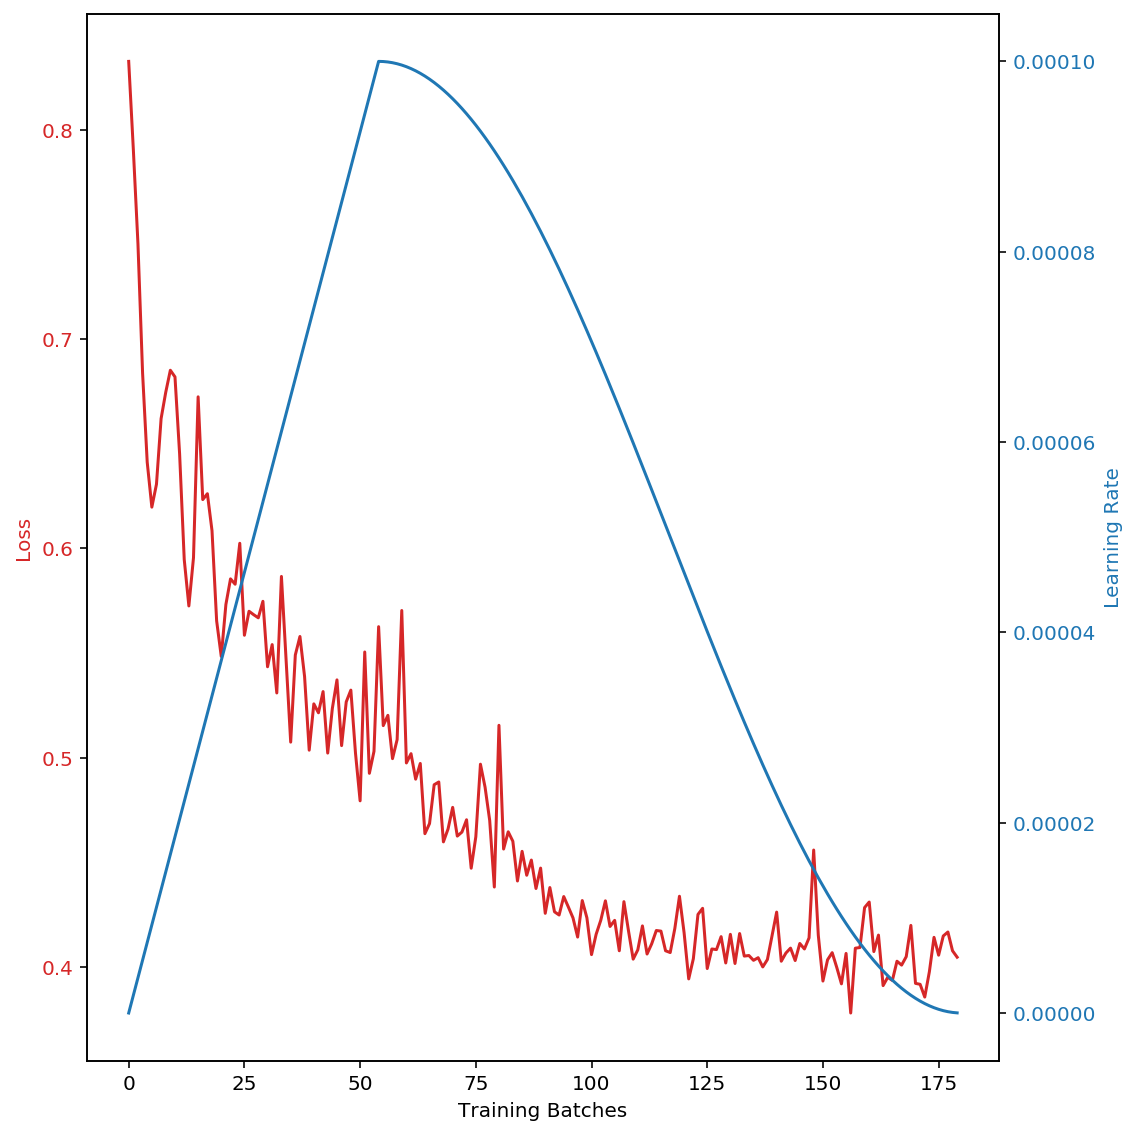

Proba       Preds    
         min   max   min max
Labels                      
0      0.282 0.652     0   1
1      0.294 0.702     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.615,"[0.38517269492149353, 0.6148272752761841]",1,1,0.484,"[0.516318142414093, 0.483681857585907]",0,0,0.377,"[0.6230295300483704, 0.376970499753952]",0,0
1,0.590,"[0.41031596064567566, 0.589684009552002]",1,0,0.499,"[0.5014156699180603, 0.4985843300819397]",0,1,0.513,"[0.48747095465660095, 0.5125290155410767]",1,1
2,0.374,"[0.6264773607254028, 0.3735225796699524]",0,0,0.609,"[0.3914175033569336, 0.6085824966430664]",1,1,0.527,"[0.47305828332901, 0.52694171667099]",1,0
3,0.549,"[0.4512242078781128, 0.5487757921218872]",1,1,0.499,"[0.5006909370422363, 0.49930906295776367]",0,1,0.478,"[0.5216802954673767, 0.4783196747303009]",0,1
4,0.447,"[0.5526008009910583, 0.4473991394042969]",0,0,0.516,"[0.48394227027893066, 0.5160577297210693]",1,0,0.466,"[0.5336969494819641, 0.4663030207157135]",0,0


scores =  {'map': '0.6922', 'acc': '0.6303', 'auc': '0.6837'}


train   val
mean_or_std metric               
mean        map       0.550 0.692
            accuracy  0.680 0.630
            auc       0.693 0.684
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.744  0.781 0.762 5040.000     0.600  0.783 0.679 660.000
pos     0.538  0.486 0.511 2640.000     0.688  0.477 0.564 660.000

In [9]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)





Autocast =  True Epochs =  48 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1



Epoch =  1 Loss = 0.399934 LR = 0.00000208



Epoch =  2 Loss = 0.401236 LR = 0.00000417



Epoch =  3 Loss = 0.397179 LR = 0.00000625



Epoch =  4 Loss = 0.401445 LR = 0.00000834



Epoch =  5 Loss = 0.400747 LR = 0.00001042



Epoch =  6 Loss = 0.395239 LR = 0.00001251



Epoch =  7 Loss = 0.403963 LR = 0.00001459



Epoch =  8 Loss = 0.393243 LR = 0.00001668



Epoch =  9 Loss = 0.389702 LR = 0.00001876



Epoch =  10 Loss = 0.394806 LR = 0.00002085



Epoch =  11 Loss = 0.384958 LR = 0.00002293



Epoch =  12 Loss = 0.387245 LR = 0.00002502



Epoch =  13 Loss = 0.379917 LR = 0.00002710



Epoch =  14 Loss = 0.373178 LR = 0.00002919



Epoch =  15 Loss = 0.370991 LR = 0.00002998


Proba       Preds    
         min   max   min max
Labels                      
0      0.233 0.785     0   1
1      0.265 0.771     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.631,"[0.36945849657058716, 0.6305414438247681]",1,0,0.416,"[0.583703875541687, 0.416296124458313]",0,0,0.490,"[0.510066032409668, 0.48993390798568726]",0,1
1,0.347,"[0.6533106565475464, 0.3466893434524536]",0,0,0.292,"[0.7081236243247986, 0.2918763756752014]",0,0,0.534,"[0.466435045003891, 0.5335649251937866]",1,1
2,0.688,"[0.31194210052490234, 0.6880578994750977]",1,0,0.427,"[0.5729308724403381, 0.4270690679550171]",0,1,0.581,"[0.41938483715057373, 0.5806151628494263]",1,0
3,0.518,"[0.4818490445613861, 0.5181509256362915]",1,0,0.663,"[0.3366231918334961, 0.6633768081665039]",1,1,0.312,"[0.6881507039070129, 0.3118492364883423]",0,1
4,0.466,"[0.5342682600021362, 0.465731680393219]",0,1,0.647,"[0.3525053858757019, 0.6474945545196533]",1,1,0.473,"[0.5274959802627563, 0.4725039601325989]",0,1


scores =  {'map': '0.6266', 'acc': '0.5760', 'auc': '0.6573'}
Epoch =  15 Train = 0.733981 Val = 0.657296



Epoch =  16 Loss = 0.374739 LR = 0.00002983



Epoch =  17 Loss = 0.378559 LR = 0.00002956



Epoch =  18 Loss = 0.378009 LR = 0.00002915



Epoch =  19 Loss = 0.364687 LR = 0.00002863



Epoch =  20 Loss = 0.365675 LR = 0.00002798



Epoch =  21 Loss = 0.366685 LR = 0.00002723



Epoch =  22 Loss = 0.362969 LR = 0.00002636



Epoch =  23 Loss = 0.358071 LR = 0.00002540



Epoch =  24 Loss = 0.366976 LR = 0.00002434



Epoch =  25 Loss = 0.355279 LR = 0.00002321



Epoch =  26 Loss = 0.356629 LR = 0.00002200


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  27 Loss = 0.350941 LR = 0.00002073



Epoch =  28 Loss = 0.354775 LR = 0.00001941



Epoch =  29 Loss = 0.353087 LR = 0.00001806



Epoch =  30 Loss = 0.346737 LR = 0.00001667



Epoch =  31 Loss = 0.347905 LR = 0.00001527



Epoch =  32 Loss = 0.345593 LR = 0.00001387



Epoch =  33 Loss = 0.345259 LR = 0.00001248



Epoch =  34 Loss = 0.347886 LR = 0.00001111


Proba       Preds    
         min   max   min max
Labels                      
0      0.117 0.756     0   1
1      0.190 0.753     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.367,"[0.6333922743797302, 0.3666077256202698]",0,1,0.596,"[0.4035380482673645, 0.5964618921279907]",1,0,0.280,"[0.7195592522621155, 0.28044065833091736]",0,0
1,0.383,"[0.6171625852584839, 0.3828374147415161]",0,1,0.427,"[0.5733509659767151, 0.42664897441864014]",0,0,0.699,"[0.3014344274997711, 0.6985656023025513]",1,1
2,0.453,"[0.5473227500915527, 0.4526771605014801]",0,0,0.590,"[0.40963825583457947, 0.5903617143630981]",1,1,0.586,"[0.4136873185634613, 0.5863126516342163]",1,0
3,0.351,"[0.6493574976921082, 0.35064244270324707]",0,1,0.441,"[0.5589843392372131, 0.4410156011581421]",0,1,0.323,"[0.6769350171089172, 0.32306498289108276]",0,1
4,0.407,"[0.592954158782959, 0.407045841217041]",0,0,0.433,"[0.566754937171936, 0.43324509263038635]",0,1,0.374,"[0.6261242628097534, 0.3738757073879242]",0,1


scores =  {'map': '0.6186', 'acc': '0.5680', 'auc': '0.6630'}
Epoch =  34 Train = 0.784919 Val = 0.662992



Epoch =  35 Loss = 0.345823 LR = 0.00000978



Epoch =  36 Loss = 0.344478 LR = 0.00000849



Epoch =  37 Loss = 0.346563 LR = 0.00000725



Epoch =  38 Loss = 0.351810 LR = 0.00000609



Epoch =  39 Loss = 0.344491 LR = 0.00000500



Epoch =  40 Loss = 0.342832 LR = 0.00000400



Epoch =  41 Loss = 0.352733 LR = 0.00000310



Epoch =  42 Loss = 0.348230 LR = 0.00000230


Proba       Preds    
         min   max   min max
Labels                      
0      0.064 0.676     0   1
1      0.149 0.742     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.419,"[0.5805191993713379, 0.4194808006286621]",0,1,0.740,"[0.26039934158325195, 0.739600658416748]",1,1,0.374,"[0.6256675720214844, 0.37433233857154846]",0,0
1,0.376,"[0.6236697435379028, 0.37633025646209717]",0,0,0.358,"[0.6416682004928589, 0.35833173990249634]",0,0,0.402,"[0.5979127883911133, 0.40208718180656433]",0,1
2,0.336,"[0.664090633392334, 0.33590930700302124]",0,1,0.324,"[0.6761407256126404, 0.32385921478271484]",0,1,0.382,"[0.6179478764533997, 0.38205212354660034]",0,1
3,0.343,"[0.6572542190551758, 0.3427457809448242]",0,0,0.452,"[0.547749400138855, 0.4522506296634674]",0,0,0.419,"[0.581170916557312, 0.418829083442688]",0,1
4,0.576,"[0.42361828684806824, 0.5763816833496094]",1,1,0.453,"[0.5473413467407227, 0.45265868306159973]",0,1,0.477,"[0.5234743356704712, 0.47652560472488403]",0,0


scores =  {'map': '0.6664', 'acc': '0.5840', 'auc': '0.6844'}
Epoch =  42 Train = 0.797356 Val = 0.684400



Epoch =  43 Loss = 0.350330 LR = 0.00000161



Epoch =  44 Loss = 0.346324 LR = 0.00000104



Epoch =  45 Loss = 0.342722 LR = 0.00000059



Epoch =  46 Loss = 0.342454 LR = 0.00000026


Proba       Preds    
         min   max   min max
Labels                      
0      0.065 0.702     0   1
1      0.150 0.797     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.357,"[0.6426663398742676, 0.35733360052108765]",0,0,0.207,"[0.7930148839950562, 0.20698507130146027]",0,0,0.305,"[0.6947792768478394, 0.30522069334983826]",0,0
1,0.382,"[0.617923378944397, 0.38207659125328064]",0,0,0.448,"[0.5521319508552551, 0.4478679597377777]",0,0,0.476,"[0.5235373377799988, 0.47646263241767883]",0,0
2,0.593,"[0.40686315298080444, 0.5931368470191956]",1,1,0.636,"[0.36365586519241333, 0.6363441348075867]",1,1,0.479,"[0.5213191509246826, 0.4786808490753174]",0,0
3,0.280,"[0.7199957370758057, 0.28000423312187195]",0,0,0.448,"[0.5516666173934937, 0.44833338260650635]",0,0,0.421,"[0.5794316530227661, 0.4205683171749115]",0,1
4,0.540,"[0.4601932168006897, 0.5398067235946655]",1,1,0.245,"[0.7546604871749878, 0.24533948302268982]",0,0,0.586,"[0.4142563045024872, 0.5857436656951904]",1,1


scores =  {'map': '0.6607', 'acc': '0.5880', 'auc': '0.6875'}
Epoch =  46 Train = 0.794666 Val = 0.687520



Epoch =  47 Loss = 0.340550 LR = 0.00000007



Epoch =  48 Loss = 0.341222 LR = 0.00000000



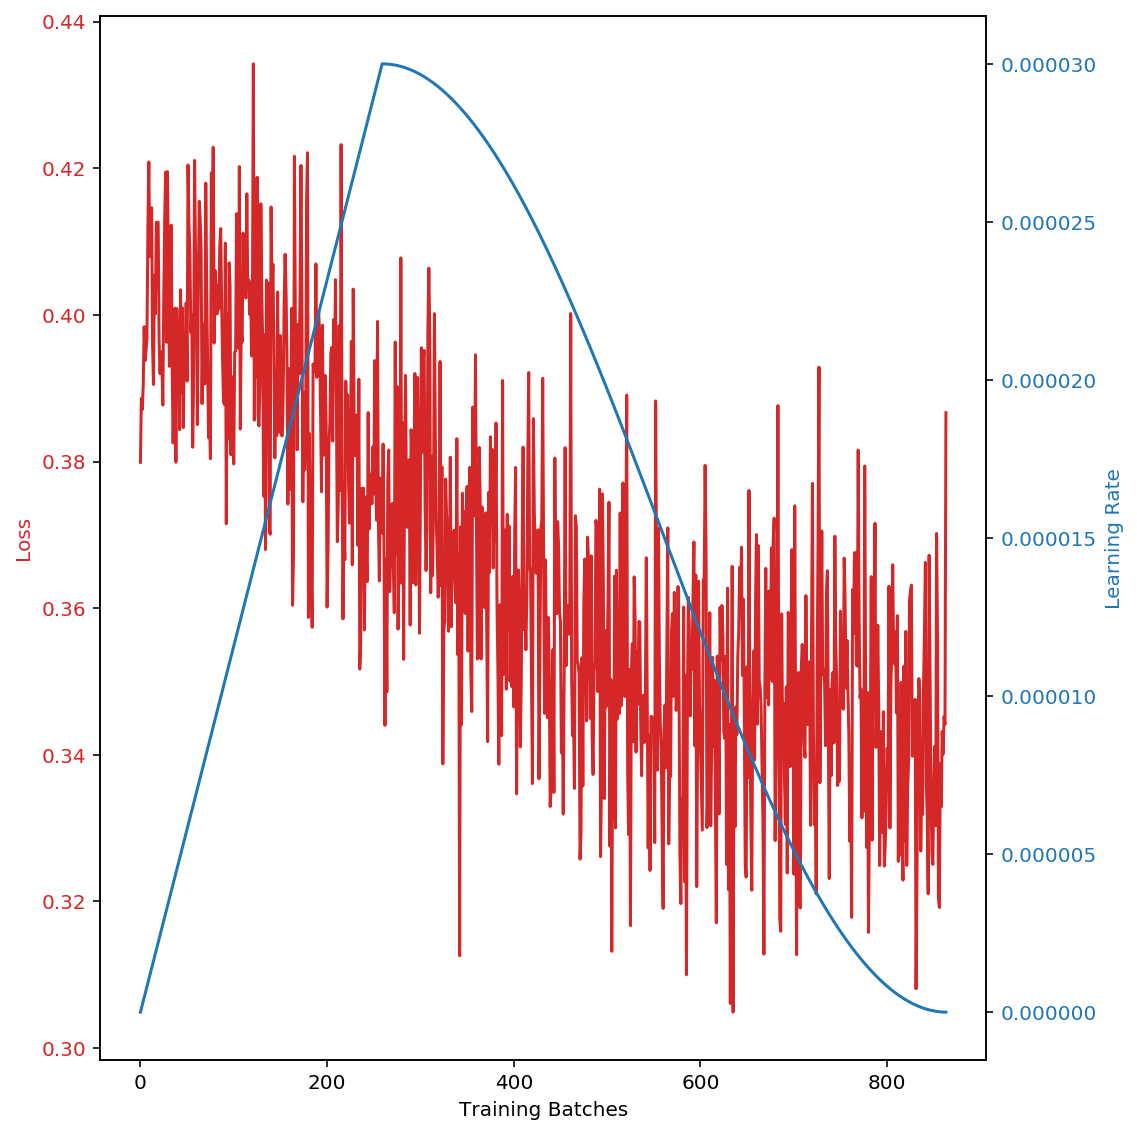

,id,proba,label
450,39206,0.667,1
783,29408,0.520,1
23,15306,0.333,0
56,5462,0.461,0
527,40316,0.544,1


In [10]:
epochs = 24
submission, text_model = train_and_predict((model, optimizer), data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 34, 42, 46],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
